In [2]:
import re
import os
from os.path import join
import json
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted
from tqdm import tqdm
from sklearn.manifold import TSNE

import torch
from torchvision.utils import save_image
from torchvision.io import read_image
import torchvision.models as models

import warnings
warnings.filterwarnings("ignore")

from experiment_utils import set_env, REPO_PATH, seed_everything
set_env()

In [18]:
from experiments.mnist_analysis import create_df

In [27]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Plot TSNE for features

In [60]:
def plot_features(df_trained_on_og, df_trained_on_cf, dataset, suffix="original", legend=True):
    fig, axes = plt.subplots(1, 2, figsize=(11, 5))

    ax = axes[0]
    ax.grid()
    ax.set_title("Trained on original", fontsize=20)
    sns.scatterplot(
        data=df_trained_on_og,
        x="Z1", y="Z2", hue="y", ax=ax, palette="deep", legend=False,
    )

    ax = axes[1]
    ax.grid()
    ax.set_title("Trained on counterfactuals", fontsize=20)
    sns.scatterplot(
        data=df_trained_on_cf,
        x="Z1", y="Z2", hue="y", ax=ax, palette="deep", legend=legend,
    )
    if legend:
        ax.legend(fontsize=16, bbox_to_anchor=(1.0, 0.95))

    save_path = join(REPO_PATH, f"experiments/results/plots/tsne_{dataset}_{suffix}.pdf")
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()

In [58]:
seed = 0
datasets = ["colored_MNIST"]
datasets_evaluated_on = ["original", "counterfactual"]

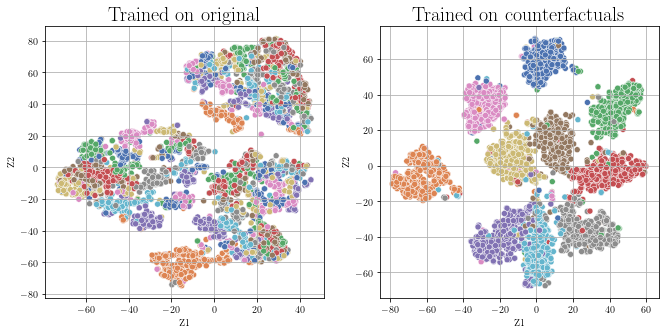

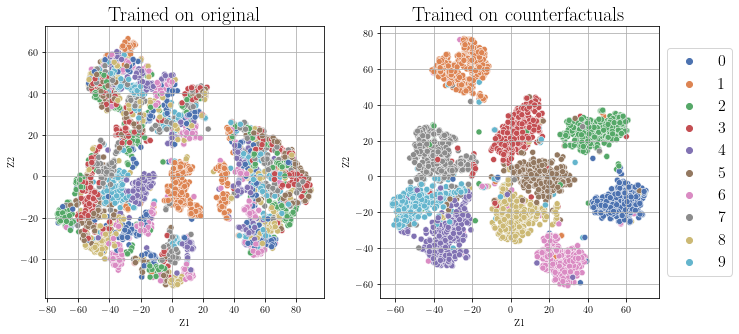

In [61]:
for dataset in datasets:
    
    results = dict()

    # visualize feature on original dataset
    expt_dir = join(
        REPO_PATH,
        f"cgn_framework/mnists/experiments/classifier_{dataset}_seed_{seed}",
    )

    for evaluated_on in datasets_evaluated_on:
        feat_path = join(expt_dir, "features", f"{dataset}_{evaluated_on}.pth")
        assert os.path.exists(feat_path), f"Features do not exist at {feat_path}"

        feat = torch.load(feat_path, map_location="cpu")
        df = create_df(feat["tsne"], feat["y"])
        results[f"trained-on-original--evaluated-on-{evaluated_on}"] = df
    
    # visualize features on counterfactual dataset
    expt_dir = join(
        REPO_PATH,
        f"cgn_framework/mnists/experiments/classifier_{dataset}_counterfactual_seed_{seed}",
    )

    for evaluated_on in datasets_evaluated_on:
        feat_path = join(expt_dir, "features", f"{dataset}_{evaluated_on}.pth")
        assert os.path.exists(feat_path), f"Features do not exist at {feat_path}"

        feat = torch.load(feat_path, map_location="cpu")
        df = create_df(feat["tsne"], feat["y"])
        results[f"trained-on-counterfactual--evaluated-on-{evaluated_on}"] = df
    
    plot_features(
        results["trained-on-original--evaluated-on-original"],
        results["trained-on-counterfactual--evaluated-on-original"],
        dataset,
        legend=False,
        suffix="original",
    )
    plot_features(
        results["trained-on-original--evaluated-on-counterfactual"],
        results["trained-on-counterfactual--evaluated-on-counterfactual"],
        dataset,
        legend=True,
        suffix="counterfactual",
    )

### Plot MNIST GradCAM results

In [79]:
def cut_heatmap_from_image(img):
    width = img.shape[-1]
    mod_img = torch.cat([img[:, :, :(width // 3)], img[:, :, 2 * (width // 3):]], dim=-1)
    return mod_img

In [62]:
seed = 0
datasets = ["colored_MNIST", "double_colored_MNIST", "wildlife_MNIST"]

In [83]:
indices = [4, 7, 2]
results = dict()

for dataset in datasets:
    # classifier trained on original data
    expt_dir = join(
        REPO_PATH,
        f"cgn_framework/mnists/experiments/classifier_{dataset}_seed_{seed}",
    )
    gradcam_image_paths = glob(join(expt_dir, "gradcam", "*.png"))
    gradcam_images_og = [cut_heatmap_from_image(read_image(x)) for x in gradcam_image_paths]
    gradcam_images_og = [gradcam_images_og[x] for x in indices]
    results[f"{dataset}-trained-on-original"] = gradcam_images_og
    
    # classifier trained on counterfactual data
    expt_dir = join(
        REPO_PATH,
        f"cgn_framework/mnists/experiments/classifier_{dataset}_counterfactual_seed_{seed}",
    )
    gradcam_image_paths = glob(join(expt_dir, "gradcam", "*.png"))
    gradcam_images_cf = [cut_heatmap_from_image(read_image(x)) for x in gradcam_image_paths]
    gradcam_images_cf = [gradcam_images_cf[x] for x in indices]
    results[f"{dataset}-trained-on-counterfactual"] = gradcam_images_cf

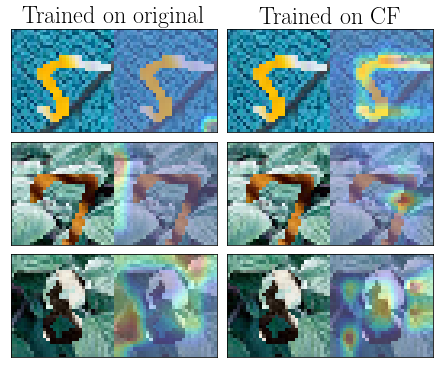

In [101]:
# plot images for a single dataset
# dataset = "colored_MNIST"
# dataset = "double_colored_MNIST"
dataset = "wildlife_MNIST"

fig, axes = plt.subplots(len(indices), 2, constrained_layout=True, figsize=(6, 5))

col = 0
images = results[f"{dataset}-trained-on-original"]
for j, img in enumerate(images):
    ax = axes[j][col]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))
    
    if j == 0:
        ax.set_title("Trained on original", fontsize=24)

col = 1
images = results[f"{dataset}-trained-on-counterfactual"]
for j, img in enumerate(images):
    ax = axes[j][col]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))

    if j == 0:
        ax.set_title("Trained on CF", fontsize=24)

plt.savefig(join(REPO_PATH, f"experiments/results/plots/gradcam_{dataset}.pdf"), bbox_inches="tight")
plt.show()

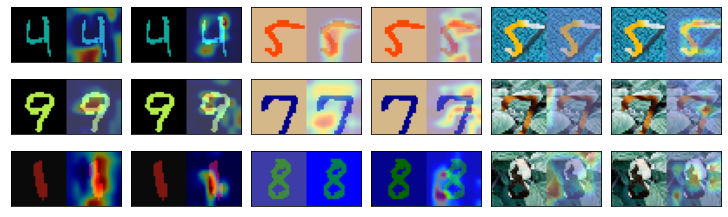

In [104]:
# plot images together

fig, axes = plt.subplots(len(indices), 2 * len(datasets), constrained_layout=True, figsize=(10, 3))

for i, dataset in enumerate(datasets):
    
    col = i * 2
    images = results[f"{dataset}-trained-on-original"]
    for j, img in enumerate(images):
        ax = axes[j][col]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img.permute(1, 2, 0))
    
    col = (i * 2) + 1
    images = results[f"{dataset}-trained-on-counterfactual"]
    for j, img in enumerate(images):
        ax = axes[j][col]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img.permute(1, 2, 0))

plt.show()

### Plot the GradCAM IoU 

In [208]:
def plot_iou_for_og_and_cf(og_path_per_dataset, cf_path_per_dataset, save=False, show=False):

    # construct df
    # df = pd.DataFrame(None)
    df = []
    for dataset in og_path_per_dataset.keys():
        og_path = og_path_per_dataset[dataset]
        cf_path = cf_path_per_dataset[dataset]
        iou_og = torch.load(og_path)
        iou_cf = torch.load(cf_path)

        df.append([dataset, "Original", iou_og["overall_mean"]])
        df.append([dataset, "Counterfactual", iou_cf["overall_mean"]])

    df = pd.DataFrame(df, columns=["dataset", "model", "iou"])
    df.replace(
        {
            "colored_MNIST": "C-MNIST",
            "double_colored_MNIST": "DC-MNIST",
            "wildlife_MNIST": "W-MNIST",
        },
        inplace=True,
    )

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    ax.grid()
    # ax.set_title("IoU of GradCAM heatmaps with ground truth", fontsize=22)
    ax.set_title("IoU between GradCAM heatmap \& GT", fontsize=22)

    # sns.barplot(data=df, x="dataset", y="iou", hue="model", palette="Paired")
    sns.barplot(data=df, x="dataset", y="iou", hue="model", palette=["skyblue", "pink"], ax=ax)
    # g.set(ylim=(0, 0.8))
    # ax.set_ylim(0, 0.8)

    ax.legend(bbox_to_anchor=(0.95, 0.98), fontsize=15, ncol=2)
    # ax.legend(bbox_to_anchor=(1.0, 0.9), fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel(ax.get_xlabel().capitalize(), fontsize=18)
    ax.set_ylabel(ax.get_ylabel().upper(), fontsize=18)
    ax.set_ylim(0, 0.6)

    if save:
        plt.savefig(
            join(REPO_PATH, "experiments", "results/plots", "quant_gradcam_iou_v2.pdf"),
            bbox_inches="tight",
        )
    
    if show:
        plt.show()

In [209]:
iou_path_og_per_dataset = dict()
iou_path_cf_per_dataset = dict()

for dataset in datasets:
    # classifier trained on original data
    expt_dir = join(
        REPO_PATH,
        f"cgn_framework/mnists/experiments/classifier_{dataset}_seed_{seed}",
    )
    iou_path_og = join(expt_dir, "gradcam", f"{dataset}_gradcam_iou_seed_{seed}.pth")
    iou_path_og_per_dataset[dataset] = iou_path_og

    # iou_og = torch.load(iou_path_og)
    # results[f"{dataset}-trained-on-original"] = iou_og
    
    # classifier trained on counterfactual data
    expt_dir = join(
        REPO_PATH,
        f"cgn_framework/mnists/experiments/classifier_{dataset}_counterfactual_seed_{seed}",
    )
    iou_path_cf = join(expt_dir, "gradcam", f"{dataset}_gradcam_iou_seed_{seed}.pth")
    iou_path_cf_per_dataset[dataset] = iou_path_cf

    # iou_cf = torch.load(iou_path_cf)
    # results[f"{dataset}-trained-on-original"] = iou_cf


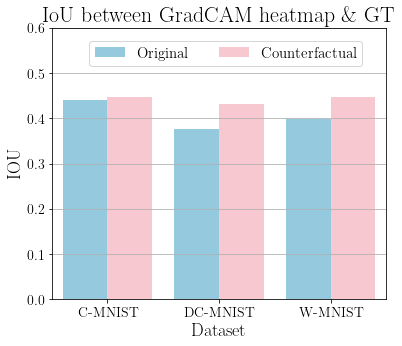

In [210]:
plot_iou_for_og_and_cf(iou_path_og_per_dataset, iou_path_cf_per_dataset, save=True)